## IMPORT LIBRARY

In [1]:
import re
import unicodedata
import pandas as pd
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

## LOAD DATASET


In [2]:
df = pd.read_csv("../Klasifikasi_Data/dataset_labeled_250.csv", delimiter=';')

## PREPROCFESSING

In [ ]:
stemmer = StemmerFactory().create_stemmer()
stopword_list = set(StopWordRemoverFactory().get_stop_words())

def clean_text(teks: str) -> str:
    if teks is None:
        return ""   
    teks = unicodedata.normalize("NFC", teks)
    teks = teks.casefold()
    teks = re.sub(r"https?://\S+|www\.\S+", " ", teks)
    teks = re.sub(r"<[^>]+>", " ", teks)
    teks = re.sub(r"[^\w\s]", " ", teks)
    teks = re.sub(r"\b\d+\b", " ", teks)
    teks = re.sub(r"\s+", " ", teks).strip()
    return teks

def preprocess(teks):
    teks_c = clean_text(teks)
    tokens = teks_c.split()
    tokens_s = [stemmer.stem(t) for t in tokens]
    tokens_f = [t for t in tokens_s if t not in stopword_list]
    return " ".join(tokens_f)

df['Processed'] = df['Comment'].apply(preprocess)

## FEATURE ENGGINERING

### TF IDF

In [4]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Processed'])

### BAG OF WORDS (BoW)

In [5]:
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['Processed'])

### WORD2VEC

In [6]:
sentences = [text.split() for text in df['Processed']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def sent_vec_w2v(tokens):
    vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_w2v = np.array([sent_vec_w2v(text.split()) for text in df['Processed']])

### GLOVE

In [7]:
# GloVe (random vectors)
def random_glove_vector(word):
    np.random.seed(abs(hash(word)) % (10**6))
    return np.random.uniform(-0.5, 0.5, 100)

def sent_vec_glove(sentence):
    words = sentence.split()
    vectors = [random_glove_vector(w) for w in words]
    return np.mean(vectors, axis=0)

X_glove = np.array([sent_vec_glove(text) for text in df['Processed']])

## LABEL ENCODING

In [8]:
y = df['Label']

## SVM

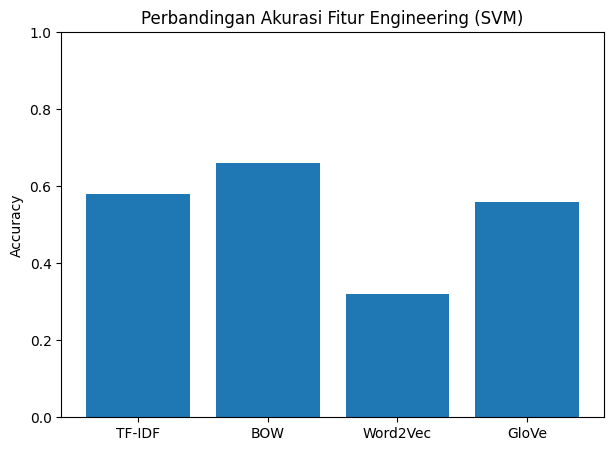

Fitur terbaik: BOW dengan akurasi 0.6600


In [9]:
def run_svm_model(X_train, X_test, y_train, y_test):
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return acc

X_features = {
    'TF-IDF': X_tfidf,
    'BOW': X_bow,
    'Word2Vec': X_w2v,
    'GloVe': X_glove
}

feature_results = {}
for name, X in X_features.items():
    X_train, X_test, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)
    acc = run_svm_model(X_train, X_test, y_train_split, y_test_split)
    feature_results[name] = acc

# Tampilkan perbandingan akurasi
plt.figure(figsize=(7,5))
plt.bar(feature_results.keys(), feature_results.values())
plt.title("Perbandingan Akurasi Fitur Engineering (SVM)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Pilih fitur terbaik
best_feature = max(feature_results, key=feature_results.get)
print(f"Fitur terbaik: {best_feature} dengan akurasi {feature_results[best_feature]:.4f}")

## UJI COBA BOW DAN SVM

In [10]:
test_sizes = [0.2, 0.3, 0.4]
random_states = [42, 7, 123]
results = []

X_best = X_features[best_feature]

for ts in test_sizes:
    for rs in random_states:
        # Tanpa stratify
        X_train, X_test, y_train_split, y_test_split = train_test_split(
            X_best, y, test_size=ts, random_state=rs
        )
        acc_no_strat = run_svm_model(X_train, X_test, y_train_split, y_test_split)

        # Dengan stratify
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            X_best, y, test_size=ts, random_state=rs, stratify=y
        )
        acc_strat = run_svm_model(X_train_s, X_test_s, y_train_s, y_test_s)

        results.append({
            'test_size': ts,
            'random_state': rs,
            'accuracy_no_stratify': acc_no_strat,
            'accuracy_stratify': acc_strat
        })

## VISUALISASI PERBANDINGAN


===== Ringkasan Akurasi Semua Percobaan =====
   test_size  random_state  accuracy_no_stratify  accuracy_stratify
0        0.2            42              0.660000           0.520000
1        0.2             7              0.520000           0.440000
2        0.2           123              0.520000           0.520000
3        0.3            42              0.640000           0.546667
4        0.3             7              0.560000           0.560000
5        0.3           123              0.546667           0.600000
6        0.4            42              0.600000           0.570000
7        0.4             7              0.530000           0.510000
8        0.4           123              0.570000           0.610000


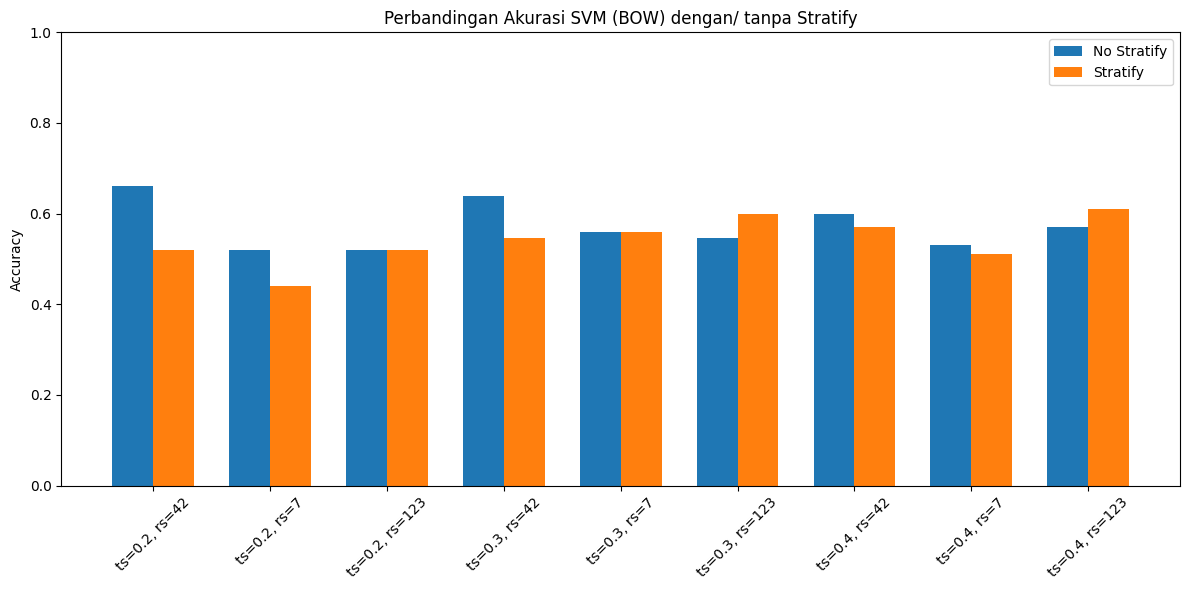

In [11]:
results_df = pd.DataFrame(results)
print("\n===== Ringkasan Akurasi Semua Percobaan =====")
print(results_df)

plt.figure(figsize=(12,6))
width = 0.35
x = np.arange(len(results_df))
plt.bar(x - width/2, results_df['accuracy_no_stratify'], width, label='No Stratify')
plt.bar(x + width/2, results_df['accuracy_stratify'], width, label='Stratify')
plt.xticks(x, [f"ts={ts}, rs={rs}" for ts, rs in zip(results_df['test_size'], results_df['random_state'])], rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title(f"Perbandingan Akurasi SVM ({best_feature}) dengan/ tanpa Stratify")
plt.legend()
plt.tight_layout()
plt.show()
